###Importing kaggle data source

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'facial-expression-recognitionferchallenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F64677%2F127160%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240509%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240509T185430Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D74157ba85dd363f8711941bfa1164b76405d1a948516e00746c2b936faa7dd6300c6d02dbd1fe2a5151a4b55b8b7834403f51aaf36176b7df3ef2633fce7671b87a9b14054f1a10914380aee648ffffde458319d7be47b076a7eb7fae713364a41c9faafec4a2981182fc96de736ec0d031df291a73b154a69af051e85e0934f57ede9705f19a95ac23a56202adc64e5ebb6541cac606b938bdb40ec71f751ccd86c17bb829f2b4dbd71d9ebcd68dd589224550417126fc54aabbd463b9b955e96bb9efa271203d129164c09ef797d4e85cbae1aa8fb3ccfa93b32a7eb17581bb0a58871c8e8731db63715e32c0a79ce3c182efa6bf1e31ed0b1d8f48f10d325'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 101283289 bytes downloaded
Downloaded and uncompressed: facial-expression-recognitionferchallenge
Data source import complete.


In [ ]:
import pandas as pdy
import numpy as np
df = pdy.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


###Data Preprocessing

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [ ]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

In [ ]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [ ]:
import keras
from keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)


###Shaping Data

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

###Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    width_shift_range=0.1,
    horizontal_flip = True,
    height_shift_range=0.1,
    fill_mode = 'nearest')
testgen = ImageDataGenerator(
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

###Training Dataset generator

In [ ]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size)
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

###CNN MODEL

In [ ]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Flatten,Dropout,Dense, BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix

def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the a block
    conva_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conva_1')(visible)
    conva_1 = BatchNormalization()(conva_1)
    conva_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conva_2')(conva_1)
    conva_2 = BatchNormalization()(conva_2)
    poola_1 = MaxPooling2D(pool_size=(2,2), name = 'poola_1')(conva_2)
    dropa_1 = Dropout(0.3, name = 'dropa_1')(poola_1)
    #the b block
    convb_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'convb_1')(dropa_1)
    convb_1 = BatchNormalization()(convb_1)
    convb_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'convb_2')(convb_1)
    convb_2 = BatchNormalization()(convb_2)
    convb_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'convb_3')(convb_2)
    convb_2 = BatchNormalization()(convb_3)
    poolb_1 = MaxPooling2D(pool_size=(2,2), name = 'poolb_1')(convb_3)
    dropb_1 = Dropout(0.3, name = 'dropb_1')(poolb_1)
    #the c block
    convc_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'convc_1')(dropb_1)
    convc_1 = BatchNormalization()(convc_1)
    convc_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'convc_2')(convc_1)
    convc_2 = BatchNormalization()(convc_2)
    convc_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'convc_3')(convc_2)
    convc_3 = BatchNormalization()(convc_3)
    convc_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'convc_4')(convc_3)
    convc_4 = BatchNormalization()(convc_4)
    poolc_1 = MaxPooling2D(pool_size=(2,2), name = 'poolc_1')(convc_4)
    dropc_1 = Dropout(0.3, name = 'dropc_1')(poolc_1)
    #the d block
    convd_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'convd_1')(dropc_1)
    convd_1 = BatchNormalization()(convd_1)
    convd_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'convd_2')(convd_1)
    convd_2 = BatchNormalization()(convd_2)
    convd_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'convd_3')(convd_2)
    convd_3 = BatchNormalization()(convd_3)
    convd_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'convd_4')(convd_3)
    convd_4 = BatchNormalization()(convd_4)
    poold_1 = MaxPooling2D(pool_size=(2,2), name = 'poold_1')(convd_4)
    dropd_1 = Dropout(0.3, name = 'dropd_1')(poold_1)

    #the e block
    conve_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conve_1')(dropd_1)
    conve_1 = BatchNormalization()(conve_1)
    conve_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conve_2')(conve_1)
    conve_2 = BatchNormalization()(conve_2)
    conve_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conve_3')(conve_2)
    conve_3 = BatchNormalization()(conve_3)
    conve_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conve_4')(conve_3)
    conve_3 = BatchNormalization()(conve_3)
    poole_1 = MaxPooling2D(pool_size=(2,2), name = 'poole_1')(conve_4)
    drope_1 = Dropout(0.3, name = 'drope_1')(poole_1)
    #Flatten and output
    flatten = Flatten(name = 'flatten')(drope_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)
    # create model
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())

    return model

##Model Summary

In [ ]:
model = FER_Model()
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conva_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conva_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 poola_1 (MaxPooling2D)      (None, 24, 24, 64)        0     

###Model Training

In [ ]:
num_epochs = 100
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

Epoch 1/100


<ipython-input-12-37e6bcd0ecfb>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow,


448/448 [==============================] - 28s 30ms/step - loss: 2.0403 - accuracy: 0.2123 - val_loss: 1.8836 - val_accuracy: 0.2449
Epoch 2/100
448/448 [==============================] - 12s 26ms/step - loss: 1.7913 - accuracy: 0.2520 - val_loss: 1.8374 - val_accuracy: 0.2483
Epoch 3/100
448/448 [==============================] - 12s 26ms/step - loss: 1.7582 - accuracy: 0.2737 - val_loss: 1.7342 - val_accuracy: 0.2887
Epoch 4/100
448/448 [==============================] - 12s 26ms/step - loss: 1.7040 - accuracy: 0.3097 - val_loss: 1.7384 - val_accuracy: 0.3410
Epoch 5/100
448/448 [==============================] - 12s 26ms/step - loss: 1.6332 - accuracy: 0.3568 - val_loss: 1.7272 - val_accuracy: 0.3709
Epoch 6/100
448/448 [==============================] - 12s 26ms/step - loss: 1.5670 - accuracy: 0.3863 - val_loss: 1.6186 - val_accuracy: 0.4071
Epoch 7/100
448/448 [==============================] - 12s 26ms/step - loss: 1.5078 - accuracy: 0.4156 - val_loss: 1.5203 - val_accuracy: 0.43

###Plotting graphs Training loss vs Validation Loss and Training Accuracy vs Validation Accuracy

<Figure size 640x480 with 0 Axes>

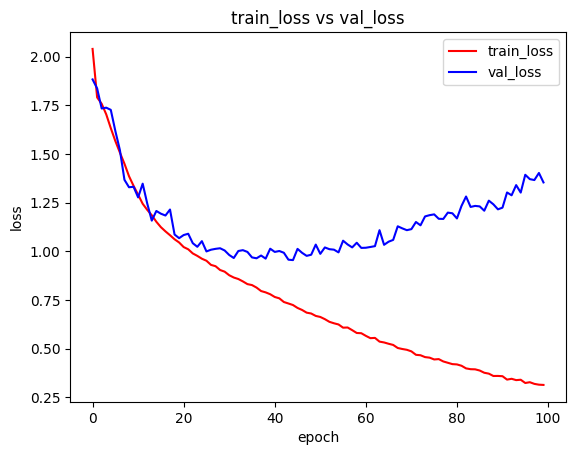

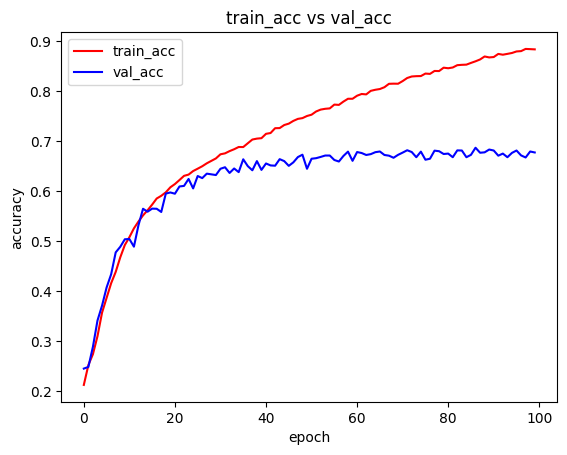

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

### Saving the Model

In [ ]:
model_json = model.to_json()
with open("model_arch.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_weights.h5")

In [ ]:
from google.colab import files
files.download('model_arch.json')
files.download('model_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Confusion Matrix


113/113 [==============================] - 0s 3ms/step


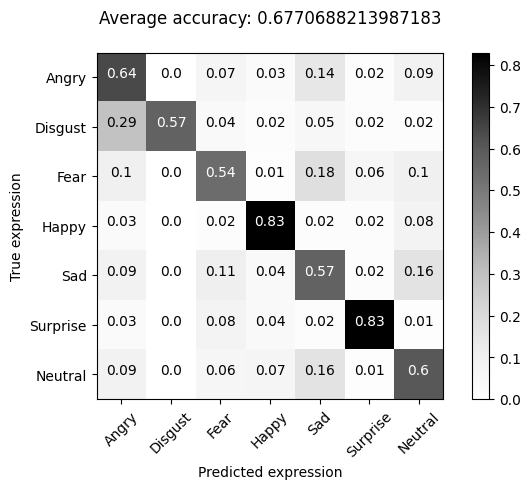

In [ ]:
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
import itertools
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    np.set_printoptions(precision=2)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

###Average Accuracy of our model is: 67.77%
